In [1]:
import sys
sys.path.append('../')
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie_perception import pcd
from magpie_control import realsense_wrapper as real
import cv2
# from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
devices = real.poll_devices()
print(devices)
wrist = real.RealSense(fps=15, w=640, h=480, device_name="D405")
wrist.initConnection(device_serial=devices['D405'])
wkspc = real.RealSense(zMax=5, fps=6, w=640, h=480, device_name="D435")
wkspc.initConnection(device_serial=devices['D435'])

{'D435': '832412070344', 'D405': '126122270157'}
There are 2 available devices!
There are 2 available devices!


In [3]:
pcd_wrist, rgbd_wrist = wrist.getPCD()
pcd_wkspc, rgbd_wkspc = wkspc.getPCD()

img_wrist = np.array(rgbd_wrist.color)
img_wkspc = np.array(rgbd_wkspc.color)

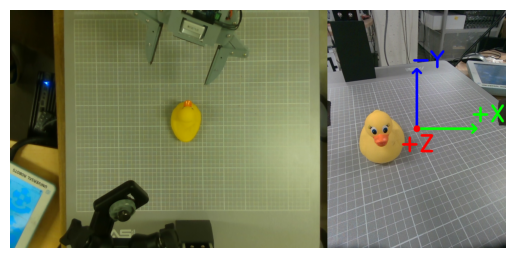

In [8]:
def label_wrist_image(wrist_img):
    '''
    labels wrist image with overlaid x,y,z axes in line with F/T sensor
    '''
    h, w, c = wrist_img.shape

    x_color = (0, 255, 0) # green
    y_color = (0, 0, 255) # blue
    z_color = (255, 0, 0) # red

    # Define axis line lengths (adjust as needed)
    axis_length = min(w, h) // 3

    # Calculate starting point for axes (center of the image)
    center_x, center_y = w // 2, h // 2

    # Draw X-axis
    cv2.arrowedLine(wrist_img, (center_x, center_y), (center_x + axis_length, center_y), x_color, 6)
    cv2.putText(wrist_img, "+X", (center_x + axis_length - 15, center_y -20), cv2.FONT_HERSHEY_SIMPLEX, 2, x_color, 6)

    # Draw Y-axis
    cv2.arrowedLine(wrist_img, (center_x, center_y), (center_x, center_y - axis_length), y_color, 6)
    cv2.putText(wrist_img, "-Y", (center_x - 15, center_y - axis_length - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, y_color, 6)

    # Draw Z-axis (pointing towards the viewer, represented as a circle)
    cv2.circle(wrist_img, (center_x, center_y), 9, z_color, -1)  # Filled circle
    cv2.putText(wrist_img, "+Z", (center_x - 45, center_y + 60), cv2.FONT_HERSHEY_SIMPLEX, 2, z_color, 6)

    return wrist_img

img_wrist_rotated = cv2.rotate(img_wrist, cv2.ROTATE_90_COUNTERCLOCKWISE)
wrist_img_labeled = label_wrist_image(img_wrist_rotated.copy()) # Use .copy() to avoid modifying the original
# img_wkspc_resized = cv2.resize(img_wkspc, (img_wrist_rotated.shape[1], img_wrist_rotated.shape[0]))
import imutils
img_wkspc_resized = imutils.resize(img_wkspc, height=img_wrist_rotated.shape[0])
final_img = np.hstack((img_wkspc_resized, wrist_img_labeled))

# save img
fn = "axes6.png"
cv2.imwrite(fn, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(final_img)

In [23]:
def openai_encode_image(image):
    import base64
    import io
    buffer = io.BytesIO()
    img = image.save(buffer, format="JPEG") # image is PIL image
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def create_image_message(text, image, model_type="gemini"):
    '''
    @param text (str): text to be sent to the model
    @param image (PIL.Image): image to be sent to the model
    '''
    message = None
    if model_type == "gemini":
        message = [text, image]
    elif model_type == "openai":
        message = {
            "role": "user",
            "content": [
                {"type": "text", "text": text},
                {
                    "type": "image_url",
                    "data": f"data:image/jpeg;base64,{openai_encode_image(image)}",
                }
            ]
        }
    return message

def send_message(client, model, messages, model_type="gemini"):
    '''
    Sends a list of messages to the specified client and model.

    @param client: The initialized OpenAI or Gemini client.
    @param model (str): The model ID to use.
    @param messages (list): A list of message dictionaries (for OpenAI) or content parts (for Gemini).
    @param model_type (str): Either "openai" or "gemini".
    @return: The response from the model.
    '''
    print(model)
    if model_type == "openai":
        response = client.chat.completions.create(
            model=model,
            messages=messages,
        )
        return response.choices[0].message.content
    elif model_type == "gemini":
        response = client.generate_content(messages)
        return response.prompt_feedback.content_filter_results if response.prompt_feedback else response.parts[0].text
    else:
        raise ValueError(f"Unsupported model type: {model_type}")


In [30]:
# with help from: https://github.com/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb
import os
from PIL import Image
from google import genai
import openai
from dotenv import load_dotenv
import instructor
from force_prediction_prompts import initial_prompt, feedback_prompt

load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
OPENAI_API_KEY = os.getenv('CORRELL_API_KEY')
GEMINI_MODEL_ID = "gemini-2.0-flash" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true}
# OPENAI_MODEL_ID = "gpt-4o-mini"
OPENAI_MODEL_ID = "gpt-4o"

gemini_client = genai.Client(api_key=GEMINI_API_KEY)
openai_client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
# model_type = "gemini"
model_type = "openai"
client, model = None, None
if model_type == "openai":
    client = openai_client
    model = OPENAI_MODEL_ID
elif model_type == "gemini":
    client = gemini_client
    model = GEMINI_MODEL_ID
img = Image.open('axes.png').convert("RGB")

obj = "small servo motor"
prompt_config = {
"obj": "small servo motor",
"task": f"slide the {obj} rapidly up the table for 10 cm"
}

prompt = initial_prompt.format(**prompt_config)

# image_response = client.models.generate_content(
#     model=model,
#     contents=[prompt, img],
# )

response = client.responses.create(
    model=model,
    input=[{
        "role": "user",
        "content": [
            {"type": "input_text", "text": f"{prompt}"},
            {
                "type": "input_image",
                "image_url": f"data:image/jpeg;base64,{openai_encode_image(img)}",
            },
        ],
    }],
)

# message_history = []
# initial_message = create_image_message(initial_prompt, img, model_type)
# message_history.append(initial_message)

# print(model_type)
# print(f"Sending initial message to {model_type}...")
# response = send_message(client, model, [initial_message] if model_type == "gemini" else message_history, model_type)
# print(f"{model_type} Response:\n{response}\n")

# # Example of a follow-up text-only message
# followup_prompt = "Now move it 2cm to the left."
# followup_message = {"role": "user", "content": followup_prompt} if model_type == "openai" else followup_prompt
# message_history.append(followup_message)

# print(f"Sending follow-up message to {model_type}...")
# followup_response = send_message(client, model, message_history, model_type)
# print(f"{model_type} Follow-up Response:\n{followup_response}")


In [49]:
from magpie_prompts.schemas import force_prediction_schema as fps
import importlib
importlib.reload(fps)

<module 'magpie_prompts.schemas.force_prediction_schema' from 'C:\\workspace\\magpie_prompts\\src\\magpie_prompts\\schemas\\force_prediction_schema.py'>

In [50]:
from magpie_prompts.schemas import force_prediction_schema

# input=[{
#     "role": "user",
#     "content": [
#         {"type": "text", "text": f"{prompt}"},
#         {
#             "type": "image_url",
#             "image_url": f"data:image/jpeg;base64,{openai_encode_image(img)}",
#         },
#     ],
# }]
input=[{
    "role": "user",
    "content": [
        prompt,
        instructor.Image.from_raw_base64(openai_encode_image(img)),
    ],
}]

openai_client_structured = instructor.from_openai(client=openai_client)
response = openai_client_structured.chat.completions.create(
    messages=input,
    response_model=force_prediction_schema.MotionForcePlan,
    model=model,
)

In [52]:
response.goal_force


AttributeError: 'MotionForcePlan' object has no attribute 'goal_force'

In [40]:
print(response.output_text)


To complete the task of sliding the small servo motor rapidly up the table for 10 cm, we'll estimate the motion direction, displacement, required forces, time, and grasping force.

### **Step 1: Initial Motion and Force Plan**

1. **Direction of Motion:**  
   Since we want to slide the servo motor up the table, this corresponds to moving in the +X direction based on the labeled axes.
   ```python
   direction = [1, 0, 0]  # +X direction
   ```

2. **Goal Position:**  
   The target displacement is 10 cm in the +X direction.
   ```python
   goal_position = [0.1, 0, 0]  # 0.1 meters in +X
   ```

3. **Goal Force:**  
   - **Mass Estimation:** Assume the small servo motor has a mass of approximately 0.05 kg.  
   - **Friction:** Coefficient of friction is assumed to be around 0.3 for a typical surface.  
   - **Force Calculation:**
     - Normal Force, \( F_N = m \cdot g = 0.05 \cdot 9.81 = 0.4905 \) N  
     - Frictional Force, \( F_f = \mu \cdot F_N = 0.3 \cdot 0.4905 \approx 0.1472 \)

In [21]:
print(image_response.text)

Okay, I understand the setup and the requested format. Here's the analysis for the desired motion:

**Desired motion description:** Grasp the {obj}

**Analysis:**

1.  **Coarse Motion:**
    *   X: 0 (No significant motion along the X-axis is required for grasping. The gripper is aligned on that axis)
    *   Y: -1 (The gripper needs to move down towards the object.)
    *   Z: 0 (No significant motion along the Z-axis is required for grasping. The gripper is aligned on that axis)

2.  **Fine Motion:**
    *   X: 0.00 (No significant motion)
    *   Y: -0.05 (Estimate the distance to move down based on the visible gap between the gripper and the object. An estimated 5cm should be enough)
    *   Z: 0.00 (No significant motion)

3.  **Coarse Forces:**
    *   X: 0 (No significant forces along the X-axis are expected initially)
    *   Y: 1 (A positive force (upwards) will be necessary to counteract gravity once the object is grasped)
    *   Z: 0 (No significant forces along the Z-axis 